In [1]:
import pandas as pd
import os
import glob
import numpy as np


In [3]:
# 데이터프레임 이름은 df로 설정
# 데이터 모든컬럼 헤더데이터 통합
df = pd.read_csv("../../data/통합데이터/Final_merged_all_data.csv")

In [8]:
cols = df.columns
# with open('columns_all.txt', 'w', encoding='utf-8') as f:
#     f.write('\n'.join(cols))
len(cols)

906

In [13]:
import pandas as pd
import numpy as np
from scipy.stats import linregress

# df = pd.read_csv("Final_merged_all_data.csv") # 데이터 로드 가정

# -------------------------------------------------------
# 1. 소비 추세 (Trend Slope) - 금액 기준 (3개 피쳐)
# -------------------------------------------------------
def calc_trend_block_slope(row):
    # 데이터 가져오기 (없으면 0)
    r12 = row.get('이용금액_신판_R12M', 0)
    r6 = row.get('이용금액_신판_R6M', 0)
    r3 = row.get('이용금액_신판_R3M', 0)
    
    # 구간별 월평균 역산
    y1 = max(0, r12 - r6) / 6  # 7~12개월 전
    y2 = max(0, r6 - r3) / 3   # 4~6개월 전
    y3 = r3 / 3                # 1~3개월 전
    
    y = np.array([y1, y2, y3])
    x = np.array([0, 1, 2])
    
    if np.sum(y) == 0: return 0
    slope, _, _, _, _ = linregress(x, y)
    mean_val = np.mean(y)
    return slope / mean_val if mean_val != 0 else 0

print("1. 소비 금액 추세(Slope) 계산 중...")
df['Trend_Score_Amount'] = df.apply(calc_trend_block_slope, axis=1)


# -------------------------------------------------------
# 2. 활동 빈도 급감 (Frequency Drop) - 건수 기준 (2개 피쳐)
# -------------------------------------------------------
# 평소(R3M 월평균) 대비 이번 달(B0M) 이용 건수 비율
col_cnt_cur = '이용건수_신용_B0M'
col_cnt_past = '이용건수_신용_R3M'

if col_cnt_cur in df.columns and col_cnt_past in df.columns:
    df['Avg_Cnt_R3M'] = df[col_cnt_past] / 3
    df['Freq_Drop_Ratio'] = np.where(df['Avg_Cnt_R3M'] > 0, 
                                     df[col_cnt_cur] / df['Avg_Cnt_R3M'], 
                                     1.0)
else:
    df['Freq_Drop_Ratio'] = 1.0


# -------------------------------------------------------
# 3. 종합 위험 점수 (Risk Score) - (5개 피쳐)
# -------------------------------------------------------
df['Risk_Total_Score'] = 0

# (1) 연체 (치명적: +50점)
if '연체잔액_B0M' in df.columns:
    df['Risk_Total_Score'] += np.where(df['연체잔액_B0M'] > 0, 50, 0)

# (2) 승인 거절 (위험: +20점)
if '승인거절건수_B0M' in df.columns:
    df['Risk_Total_Score'] += np.where(df['승인거절건수_B0M'] > 0, 20, 0)

# (3) 부실 위험형 대출 (주의: 각 +10점)
risky_cols = ['잔액_현금서비스_B0M', '잔액_카드론_B0M', '잔액_리볼빙일시불이월_B0M']
for col in risky_cols:
    if col in df.columns:
        # 잔액이 10만원 이상 남아있으면 위험 신호로 간주
        df['Risk_Total_Score'] += np.where(df[col] > 100000, 10, 0)


# -------------------------------------------------------
# 4. 저관여/휴면 (Disengagement) - (3개 피쳐)
# -------------------------------------------------------
# (1) 장기 무실적 (직접 이탈)
col_inactive = '연속무실적개월수_기본_24M_카드'
cond_dormant = (df[col_inactive] >= 2) if col_inactive in df.columns else False

# (2) 체리피킹 중단 (혜택 수혜율 0% & 한도 소진율 5% 미만 -> 카드 방치)
cond_ignore = False
if '혜택수혜율_R3M' in df.columns and '잔액_신판평균한도소진율_r3m' in df.columns:
    cond_ignore = (df['혜택수혜율_R3M'] == 0) & (df['잔액_신판평균한도소진율_r3m'] < 5)


# -------------------------------------------------------
# 5. 최종 타겟 생성 (Churn_Advanced)
# -------------------------------------------------------
# 조건 중 하나라도 해당하면 이탈(1)
# 1. 금액 추세 급락 (기울기 -0.4 이하)
# 2. 이용 건수 급감 (평소의 30% 미만)
# 3. 위험 점수 과다 (50점 이상)
# 4. 완전 휴면 (2개월 이상 무실적)
# 5. 카드 방치 (혜택X, 사용X)

df['Churn_Advanced'] = np.where(
    (df['Trend_Score_Amount'] <= -0.4) | 
    (df['Freq_Drop_Ratio'] <= 0.3) | 
    (df['Risk_Total_Score'] >= 50) | 
    cond_dormant | 
    cond_ignore,
    1, 0
)

print("\n[13개 피쳐 기반 정밀 이탈 타겟 생성 완료]")
print(df[['발급회원번호', 'Trend_Score_Amount', 'Freq_Drop_Ratio', 'Risk_Total_Score', 'Churn_Advanced']].head(10))
print("\n이탈 예측 비율 (Churn_Advanced):")
print(df['Churn_Advanced'].value_counts(normalize=True))

1. 소비 금액 추세(Slope) 계산 중...

[13개 피쳐 기반 정밀 이탈 타겟 생성 완료]
  발급회원번호  Trend_Score_Amount  Freq_Drop_Ratio  Risk_Total_Score  \
0  SYN_0           -0.558805         1.222222                10   
1  SYN_1           -0.234069         0.906977                 0   
2  SYN_2           -0.018699        -3.000000                 0   
3  SYN_3           -1.067427         1.071429                 0   
4  SYN_4           -2.081336         1.000000                 0   
5  SYN_5            0.000000         1.000000                 0   
6  SYN_6           -2.116408         1.000000                 0   
7  SYN_7           -1.791801         0.000000                 0   
8  SYN_8           -0.021278         0.943820                 0   
9  SYN_9           -0.411823         1.200000                 0   

   Churn_Advanced  
0               1  
1               1  
2               1  
3               1  
4               1  
5               1  
6               1  
7               1  
8               0  
9      

In [15]:
# -------------------------------------------------------
# [전제 조건] 앞서 만든 13개 피쳐 기반 중간 변수들이 df에 있어야 합니다.
# 필요한 컬럼: 'Risk_Total_Score', 'Trend_Score_Amount', 'Freq_Drop_Ratio'
# -------------------------------------------------------

# 1. Churn_Total_Score 초기화
df['Churn_Total_Score'] = 0.0

# -------------------------------------------------------
# [Scoring 1] 재무 위험 (배점 40점)
# -------------------------------------------------------
# 이미 계산된 Risk_Total_Score 사용 (최대 40점으로 제한)
if 'Risk_Total_Score' in df.columns:
    df['Churn_Total_Score'] += df['Risk_Total_Score'].clip(upper=40)

# -------------------------------------------------------
# [Scoring 2] 소비 추세 (배점 30점)
# -------------------------------------------------------
# 기울기가 음수일 때만 점수 부여 (기울기 절대값 * 50)
if 'Trend_Score_Amount' in df.columns:
    trend_points = np.where(df['Trend_Score_Amount'] < 0, 
                            np.abs(df['Trend_Score_Amount']) * 50, 
                            0)
    df['Churn_Total_Score'] += np.minimum(trend_points, 30)

# -------------------------------------------------------
# [Scoring 3] 활동 빈도 (배점 30점)
# -------------------------------------------------------
# 비율이 1.0 미만일 때 점수 부여 ((1 - 비율) * 30)
if 'Freq_Drop_Ratio' in df.columns:
    freq_points = np.where(df['Freq_Drop_Ratio'] < 1.0, 
                           (1.0 - df['Freq_Drop_Ratio']) * 30, 
                           0)
    df['Churn_Total_Score'] += freq_points

# -------------------------------------------------------
# [Scoring 4] 치명적 상태 (강제 100점)
# -------------------------------------------------------
# 휴면이거나 방치 상태면 100점 (Churn_Advanced가 1이 되는 조건 중 강력한 것들)
col_inactive = '연속무실적개월수_기본_24M_카드'
cond_dormant = (df[col_inactive] >= 2) if col_inactive in df.columns else False

cond_ignore = False
if '혜택수혜율_R3M' in df.columns and '잔액_신판평균한도소진율_r3m' in df.columns:
    cond_ignore = (df['혜택수혜율_R3M'] == 0) & (df['잔액_신판평균한도소진율_r3m'] < 5)

df['Churn_Total_Score'] = np.where(cond_dormant | cond_ignore, 
                                   100, 
                                   df['Churn_Total_Score'])

# -------------------------------------------------------
# [마무리] 100점 만점 처리 및 정수 변환
# -------------------------------------------------------
df['Churn_Total_Score'] = df['Churn_Total_Score'].clip(0, 100).astype(int)

# -------------------------------------------------------
# [결과 확인] 두 컬럼 나란히 비교
# -------------------------------------------------------
print("✅ 컬럼 생성 완료: 'Churn_Advanced'(0/1) & 'Churn_Total_Score'(0~100)")

# 주요 피쳐와 함께 확인
check_cols = ['발급회원번호', 'Trend_Score_Amount', 'Churn_Advanced', 'Churn_Total_Score']
print(df[check_cols].head(10))

# 이탈자(1)들의 평균 점수 확인
print("\n[이탈자(1) 그룹의 평균 위험 점수]")
print(df[df['Churn_Advanced'] == 1]['Churn_Total_Score'].describe())

✅ 컬럼 생성 완료: 'Churn_Advanced'(0/1) & 'Churn_Total_Score'(0~100)
  발급회원번호  Trend_Score_Amount  Churn_Advanced  Churn_Total_Score
0  SYN_0           -0.558805               1                 37
1  SYN_1           -0.234069               1                100
2  SYN_2           -0.018699               1                100
3  SYN_3           -1.067427               1                100
4  SYN_4           -2.081336               1                100
5  SYN_5            0.000000               1                100
6  SYN_6           -2.116408               1                100
7  SYN_7           -1.791801               1                 60
8  SYN_8           -0.021278               0                  2
9  SYN_9           -0.411823               1                100

[이탈자(1) 그룹의 평균 위험 점수]
count    35445.000000
mean        90.620426
std         23.521265
min         20.000000
25%        100.000000
50%        100.000000
75%        100.000000
max        100.000000
Name: Churn_Total_Score, dtype: fl

In [19]:
df['Churn_Advanced'].value_counts(normalize=True)

Churn_Advanced
1    0.59075
0    0.40925
Name: proportion, dtype: float64

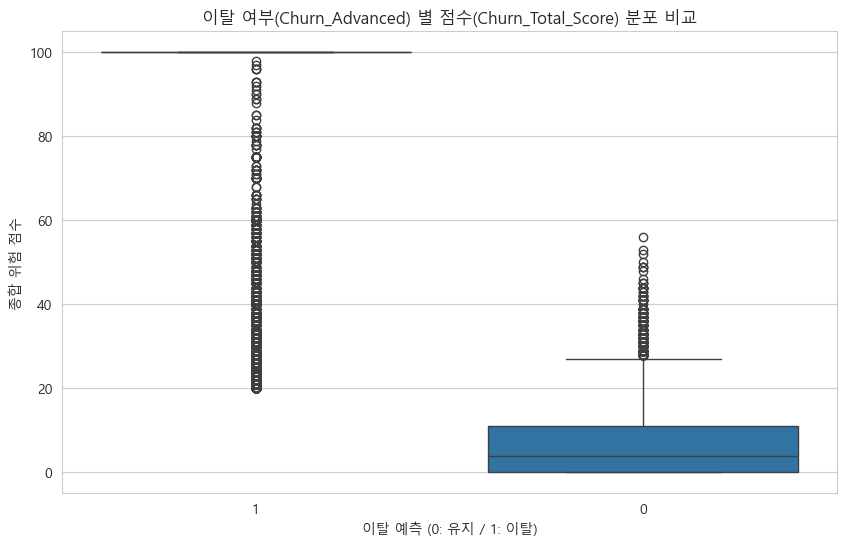

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

# 한글 폰트 설정 (Windows 기준)
font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

# 박스플롯 그리기
plt.figure(figsize=(10, 6))
sns.boxplot(x='Churn_Advanced', y='Churn_Total_Score', data=df)
plt.title('이탈 여부(Churn_Advanced) 별 점수(Churn_Total_Score) 분포 비교')
plt.xlabel('이탈 예측 (0: 유지 / 1: 이탈)')
plt.ylabel('종합 위험 점수')
plt.show()
